Messo in questa directory temporaneamente perchè non mi funziona l'import per la funzione *read_data*

In [79]:
import pandas as pd
import matplotlib.pyplot as plt

In [11]:
data = read_data("data.csv")

# drops rows with duplicat Name, since conditioning and nnz is the same
unique_data = data.drop_duplicates(subset='Name', keep="first")
unique_data

,Name,Rows,Columns,Error,Memory,Time,Language,OS,Nnz,Cond
0,apache2,715176,715176,2.235941e-08,0.004471,66.232192,1,0,4817870,5.316861e+06
4,cfd1,70656,70656,6.628463e-12,0.003326,4.461982,1,0,1825580,1.335081e+06
8,cfd2,123440,123440,1.334161e-10,0.003326,10.917099,1,0,3085406,3.728473e+06
12,ex15,6867,6867,5.281170e-05,0.003326,0.015078,1,0,98671,1.432642e+13
16,G3_circuit,1585478,1585478,3.452568e-09,210.620559,27.939265,1,0,7660826,2.238425e+07
20,parabolic_fem,525825,525825,8.836779e-10,0.003326,6.439602,1,0,3674625,2.110820e+05
24,shallow_water1,81920,81920,6.923992e-14,9.067514,0.615064,1,0,327680,3.628000e+00


Il file *data_aggregation.csv* contiene un'aggregazione dei dati delle matrici, con le proprietà fisse che restano invariate, mentre time error e memory, che variano a seconda di OS e linguaggio, vengono aggregate attraverso una media

Ne scaturisce una tabella di 7 righe: una per ciascuna matrice, senza righe duplicate

Sarà utile in seguito per alcune analisi effettuate, soprattuto il clustering

In [65]:
data = pd.read_csv("data.csv")
unique_data = data.drop_duplicates(subset='Name', keep="first")
matrix_names = unique_data.Name.tolist()
agg_data = pd.DataFrame(columns=["Name", "Rows", "avgError", "avgMemory", "avgTime", "Nnz", "Cond"])

for i in range(len(matrix_names)):
    name = unique_data.iloc[i].Name
    sub_data = data[data.Name == name]
    sub_data
    agg_data.loc[i] = [unique_data.iloc[i].Name, unique_data.iloc[i].Rows, sub_data["Error"].mean(), sub_data["Memory"].mean(), 
                        sub_data["Time"].mean(), unique_data.iloc[i].Nnz, unique_data.iloc[i].Cond]

write_data(agg_data, "data_aggregation.csv")
agg_data

,Name,Rows,avgError,avgMemory,avgTime,Nnz,Cond
0,apache2,715176,1.120165e-08,1444.600346,44.545248,4817870,5.316861e+06
1,cfd1,70656,3.371027e-12,296.911774,3.781485,1825580,1.335081e+06
2,cfd2,123440,6.687547e-11,583.295888,9.181369,3085406,3.728473e+06
3,ex15,6867,2.672326e-05,1.571187,0.023189,98671,1.432642e+13
4,G3_circuit,1585478,1.728072e-09,1669.203346,25.034213,7660826,2.238425e+07
5,parabolic_fem,525825,4.423640e-10,286.514813,5.170140,3674625,2.110820e+05
6,shallow_water1,81920,3.475360e-14,12.659260,0.469546,327680,3.628000e+00


## Come cresce l'errore al crescere del Condizionamento?

Come ci si poteva aspettare, la crescita dell'errore è direttamente proporzionale alla crescita del condizionamento della matrice: per questo ex15, pur essendo la matrice più piccola, è quella con errore più grande

(Dal momento che il condizionamento è stato calcolato su MATLAB, l'errore considerato è quello di MATLAB, OS Windows ma era indifferente dal momento che le analisi hanno evidenziato che gli errori non cambiano tra diversi OS)

C:\Users\simon\AppData\Local\Temp\ipykernel_10668\781055295.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_data.sort_values(by="Cond", inplace=True)


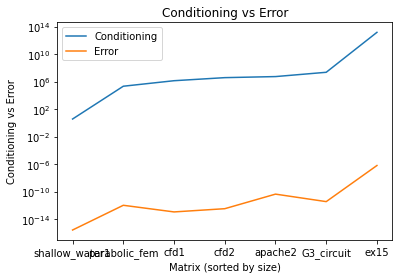

In [71]:
sub_data = data[(data.OS == 0) & (data.Language == 0)]

sub_data.sort_values(by="Cond", inplace=True)

cond_list = sub_data.Cond.tolist()
error_list = sub_data.Error.tolist()

matrix_names = sub_data.Name.tolist()

plt.plot(matrix_names,cond_list, label="Conditioning")
plt.plot(matrix_names,error_list, label="Error")
plt.title('Conditioning vs Error')
plt.xlabel('Matrix (sorted by size)')
plt.ylabel('Conditioning vs Error')
plt.yscale("log")
plt.legend()
plt.show()

## Come aumenta il tempo di esecuzione in relazione alla Densità della Matrice?

Dalle analisi precedenti è emerso come il tempo di esecuzione non dipenda solamente dalla dimensione della matrice, ma anche dalla forma che i dati al suo interno assumono: una matrice grande, i cui dati sono distribuiti attorno alla diagonale principale, richiede meno tempo di una più piccola, i cui dati sono però più dispersi

Con questa analisi l'obiettivo è quello di capire se questa distribuzione dei dati è esprimibile attraverso un valore numerico, e verrà quindi analizzato se c'è una correlazione causale tra la densità della matrice (data dal rapporto dei valori non-zeri e la dimensione dell'intera matrice) e il tempo di esecuzione necessario per applicarvi la decomposizione di Cholesky

Non sembra però esserci correlazione, il che è dovuto al fatto che le matrici più dense risultano essere proprio quelle di dimensioni minori, e pertanto richiedono tempo minore di esecuzione nonostante il rapporto di valori diversi da zero rispetto al totale è più alto in proporzione

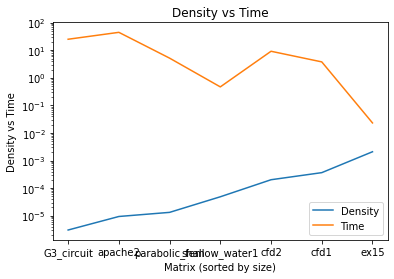

In [75]:
agg_data["Density"] = agg_data.Nnz / ((agg_data.Rows)**2)
agg_data.head(len(agg_data))

agg_data.sort_values(by="Density", inplace=True)
agg_data


density_list = agg_data.Density.tolist()
time_list = agg_data.avgTime.tolist()

matrix_names = agg_data.Name.tolist()

plt.plot(matrix_names,density_list, label="Density")
plt.plot(matrix_names,time_list, label="Time")
plt.title('Density vs Time')
plt.xlabel('Matrix (sorted by size)')
plt.ylabel('Density vs Time')
plt.yscale("log")
plt.legend()
plt.show()

## Clustering delle Matrici

Tentativo di usare Clustering sulle matrici, per analizzare la suddivisione automatica scaturita da un k-means, con una conseguente interpretazione dei cluster scaturiti

L'algoritmo è stato provato sia con *k=3* che *k=4*, ma il secondo dà risultati più sensati

L'attributo Cond è stato rimosso, perchè sfasava tutto

**(Piccole)**: *ex15* ed *shallow_water* sono tra le più piccole, e inoltre hanno una forma simile, con i dati distribuiti attorno alla diagonale principale, quindi ci sta che siano insieme

**(Medie)**: *cfd1* e *cfd2* si trovano insieme, il che era prevedibile essendo due matrci molto simili, sia per dimensioni che forma

**(Grandi)**: *parabolic_fem* si trova isolata insieme ad *apache2*, il che va bene, dal momento che sono quelle con la forma più particolare, dimensioni simili 

**(Molto Grande)**: *G3* resta isolato, e ha senso perchè è la più grande, ha una forma particolare e poche proprietà in comune con le altre

Il clustering risultante sembra essere fatto molto bene, in quanto non si sofferma a classificare le matrici esclusivamente in base alla loro dimensione, ma tiene conto anche delle altre proprietà delle matrici, come dimostarto dal fatto che sebbene *cfd1* sia leggermente più piccola di *shallow_water*, si trova comunque nel cluster assieme alla matrice "sorella" *cfd2*


In [120]:
# Convert DataFrame to matrix
clustering_data = agg_data.drop(columns=['Name', 'Cond'])
mat = clustering_data.values

# Using sklearn
km = sklearn.cluster.KMeans(n_clusters=4)
km.fit(mat)

# Get cluster assignment labels
labels = km.labels_

# Format results as a DataFrame
agg_data["cluster"] = labels
agg_data.sort_values(by="cluster", inplace=True)
agg_data

,Name,Rows,avgError,avgMemory,avgTime,Nnz,Cond,Density,cluster
4,G3_circuit,1585478,1.728072e-09,1669.203346,25.034213,7660826,2.238425e+07,0.000003,0
3,ex15,6867,2.672326e-05,1.571187,0.023189,98671,1.432642e+13,0.002092,1
2,cfd2,123440,6.687547e-11,583.295888,9.181369,3085406,3.728473e+06,0.000202,2
0,apache2,715176,1.120165e-08,1444.600346,44.545248,4817870,5.316861e+06,0.000009,2
1,cfd1,70656,3.371027e-12,296.911774,3.781485,1825580,1.335081e+06,0.000366,3
5,parabolic_fem,525825,4.423640e-10,286.514813,5.170140,3674625,2.110820e+05,0.000013,3
6,shallow_water1,81920,3.475360e-14,12.659260,0.469546,327680,3.628000e+00,0.000049,3
